## **Gabe Davidson - Final Project**

2338642
---
gadavidson@chapman.edu
---
CPSC-392
---
Final Project
---

https://www.bmc.com/blogs/mean-squared-error-r2-and-variance-in-regression-analysis/#:~:text=There%20is%20no%20correct%20value,means%20the%20model%20is%20perfect.

https://stackoverflow.com/questions/37367405/python-scikit-learn-cant-handle-mix-of-multiclass-and-continuous

In [ ]:
# import necessary packages

import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import numpy as np
from plotnine import *
from plotnine.data import mtcars
import seaborn as sns

from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score #model evaluation

%precision %.7g
%matplotlib inline

In [ ]:
# import datasets
cluster_regions = pd.read_csv("https://raw.githubusercontent.com/gabedavidson/CPSC-392-Final-Project/main/cluster_regions.csv")
item_ids = pd.read_csv("https://raw.githubusercontent.com/gabedavidson/CPSC-392-Final-Project/main/item_ids.csv")
match_data = pd.read_csv("https://raw.githubusercontent.com/gabedavidson/CPSC-392-Final-Project/main/match.csv")
purchase_log = pd.read_csv("https://github.com/gabedavidson/CPSC-392-Final-Project/blob/main/purchase_log_limited.csv?raw=true")
player_data = pd.read_csv("https://raw.githubusercontent.com/gabedavidson/CPSC-392-Final-Project/main/players_limited.csv")

In [ ]:
# Dataset shapes before cleaning (for context)
print(cluster_regions.shape)
print(item_ids.shape)
print(match_data.shape)
print(purchase_log.shape)
print(player_data.shape)

(53, 2)
(189, 2)
(50000, 13)
(1602897, 4)
(99050, 73)


In [ ]:
# clean datasets
cluster_regions = cluster_regions.dropna()
cluster_regions.reset_index(inplace=True)

item_ids = item_ids.dropna()
item_ids.reset_index(inplace=True)

purchase_log = purchase_log.dropna()
purchase_log.reset_index(inplace=True)

In [ ]:
# cleaning match_data and removing unnecessary categories
match_data.drop(['first_blood_time', 'game_mode', 'negative_votes', 'positive_votes', 'duration', 'start_time'], axis=1, inplace=True)
match_data.dropna(inplace=True)
match_data.reset_index(inplace=True)

In [ ]:
# cleaning player_data and removing unnecessary categories
player_data.drop(player_data.columns[23:], axis=1, inplace=True)
player_data.drop(['stuns','gold_spent', 'hero_damage', 'hero_healing', 'tower_damage', 'account_id'], axis=1, inplace=True)
player_data.dropna(inplace=True)
player_data.reset_index(inplace=True)

In [ ]:
# Datasets after cleaning (for context)
print(cluster_regions.shape)
print(item_ids.shape)
print(match_data.shape)
print(purchase_log.shape)
print(player_data.shape)

(53, 3)
(189, 3)
(50000, 8)
(1602897, 5)
(99050, 18)


## **Some helpful functions...**

Since I need to use data that is all over the many datasets I have, I put some time into making a bunch of helper functions so that I can manipulate my data consistently and effectively! (Plus I snuck in a logistic regression model function since, in my first question, I am going to be creating a bunch of them and don't want to remake the same over and over again! Yay functions!)

In [ ]:
def create_secondary_dataframe(dataframes, cols_map, override_col=True):
  """
  dataframes: list[pd.DataFrame] -> a list of dataframes to draw data from
  cols_map: dict{(index: int) : list[col: str]} -> a dictionary where each key corresponds to a DataFrame in dataframes* and each value is a list of columns to grab from the corresponding dataframe

  returns: pd.DataFrame
  """
  if len(dataframes) != len(cols_map):
    raise Exception("Index lengths do not match.")

  data = pd.DataFrame()
  for dataset_index, cols in cols_map.items():
    for col in cols:
      name = col
      if not override_col:
        if name in data:
          name = name + str(dataset_index)
      data[name] = dataframes[dataset_index][col]


  return data

In [ ]:
def replace_col_by_conditions(dataframe, to_replace, replace_to, conditions, names=[1, 0], arbitrary=-1, int_conditions=True):
  """
  dataframe: pd.DataFrame -> the dataframe to manipulate
  to_replace: str -> the column to replace, ex: ['player_slot']
  replace_to: list[str] -> column names to replace to, ex: ['is_radiant']
  conditions: list[list[replace_to index: int], list[condition], ...] -> replace conditions, ex: [[0, 0], [0,4], [128, 132]]
  names: list[str] -> what you want to replace that col x row cell with by index, where the true condition is index 0 and false is index 1, ex: [True, False]
  int_conditions: bool -> whether or not conditions are integers

  returns: pd.DataFrame
  """

  if len(conditions) - 1 != len(names):
    raise Exception("Each condition result must have a name.")

  data = dataframe
  index = -1

  for col in replace_to:
    data[col] = None
  for value in data[to_replace]: # some value in the dataframe in a certain column, ex: 3
    index += 1
    name_index = -1
    condition_index = 0
    # for replace_col_index, _conditions in conditions.items(): # some index (which col to replace value at) and some set of conditions to test value on, ex: 0, [0, 4]
    for replacement_col in conditions[0]:
      name_index += 1
      condition_index += 1
      if int_conditions:
        if min(conditions[condition_index]) <= value <= max(conditions[condition_index]): # check whether value fits conditions, ex: if 0 <= 3 <= 4
          data[replace_to[replacement_col]].iloc[index] = names[name_index] # assigns to certain replace_to col at index *index to names[1] (true index)
          break
        else:
          data[replace_to[replacement_col]].iloc[index] = arbitrary # data that does not fit any condition
      else: # string conditions are assumed
        if value in conditions[condition_index]:
          data[replace_to[replacement_col]].iloc[index] = names[name_index]
          break
        else:
          data[replace_to[replacement_col]].iloc[index] = arbitrary
  
  data.drop([to_replace], axis=1, inplace=True)
  return data

In [ ]:
def replace_col_by_contingency(dataframe, to_replace, replace_to, contingent_on, contingency_matrix=[0, 1], delete_contingency=False, arbitrary=-1):
  """
  dataframe: pd.DataFrame -> dataframe to manipulate
  to_replace: str -> column to replace
  replace_to: str -> column to create and replace values into
  contingent_on: str -> column to check (assumes boolean values initially)
  contingency_matrix: list[int] -> how to manipulate data
  delete_contingency: bool -> whether to delete contingent_on col
  arbitrary: int -> replace values that do meet any condition with this
  """
  
  data = dataframe
  data[replace_to] = None
  index = -1

  false = contingency_matrix[0]
  true = contingency_matrix[1]

  for value in data[to_replace]:
    index += 1
    if value == data[contingent_on].iloc[index]:
      data[replace_to].iloc[index] = contingency_matrix[true]
    elif value != data[contingent_on].iloc[index]:
      data[replace_to].iloc[index] = contingency_matrix[false]
    else:
      data[replace_to].iloc[index] = arbitrary

  data.drop([to_replace], axis=1, inplace=True)
  if (delete_contingency):
    data.drop([contingent_on], axis=1, inplace=True)

  return data


In [ ]:
def extend_value_down(dataframe, col, step, start=0):
  """
  dataframe: pd.DataFrame -> dataframe to manipulate
  col: str -> column to manipulate
  step: int -> number of indices to extend value by
  start: int -> index to start at
  """

  data = dataframe
  value = None

  for index in range(start, int(data.shape[0]), step):
    value = data[col].iloc[index]
    for row in range(index + 1, index + step):
      data[col].iloc[row] = value

  return data


In [ ]:
def replace_values_by_col(dataframe, to_replace, replace_by, start=0):
  data = dataframe

  for index in range(start, int(data.shape[0])):
    data[to_replace].iloc[index] = data[replace_by].iloc[index]

  return data

In [ ]:
def condense_rows_up(dataframe, skip=None, operation='+', step=5, start=0):
  """
  """
  
  data = dataframe
  features = list(data.columns)

  for feature in features:
    if feature in skip:
      continue
    for index in range(start, int(data.shape[0] / step)):
      for i in range(step-1):
        if operation == '+':
          data[feature].iloc[index * step + i]


In [ ]:
def do_logistic_regression(dataframe, _predictors, product, cont = None, tts = None, test_size = .2, drop = None):
  """
  dataframe: pd.DataFrame -> the dataset in question
  product: str -> what we are predicting
  cont: list[str] -> list of columns containing continous data
      -> if cont is None we assume that all data is continuous
  tts: list[Train Test Split!] -> in case I want to reuse the same training/testing data
  test_size: float -> size of test set
  drop: list[str] -> list of columns to drop before doing logistic regression

  return: pd.DataFrame
  """

  data = dataframe;
  predictors = _predictors.copy()

  if drop is not None:
    for feature in drop:
      predictors.remove(feature)

  X = data[predictors]
  y = data[product]
  y = y.astype('int') # avoiding unknown label error

  X_train, X_test, y_train, y_test = None, None, None, None

  results = {"model": None, 'preds': None, 'coef': None, "accuracy_score": None, "R2": None, 'MSE': None}

  if tts is None:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    z = StandardScaler()
    if cont is None: # all data is continuous
      z.fit(X_train)
      X_train = z.transform(X_train)
      X_test = z.transform(X_test)
    else: # cont data has been specified
      z.fit(X_train[cont])
      X_train = z.transform(X_train[cont])
      X_test = z.transform(X_test[cont])
  else:
    try:
      # this assumes that TTS continuous data passed in is already z-scored!
      X_train, X_test, y_train, y_test = tts[0], tts[1], tts[2], tts[3]
    except:
      raise Exception("TTS parameter input invalid!")

  logit = LogisticRegression(penalty="none")
  logit.fit(X_train, y_train)
  
  results['model'] = logit
  results['preds'] = logit.predict(X_test)
  results['coef'] = pd.DataFrame({"Coefs": logit.coef_[0], "Names": predictors})
  results['accuracy_score'] = accuracy_score(y_test, results['preds'])
  results['R2'] = r2_score(y_test, results['preds'])
  results['MSE'] = mean_squared_error(y_test, results['preds'])
  results['X_test'] = X_test
  results['y_test'] = y_test
  return results


## **Question 1: Data Setup!**

In the following cells I will utilize the above helper functions to create pull data from many datasets and into one! Also, I will need to change certain features into others...!

In [ ]:
# create dataframe with pertinent data
q1_data = create_secondary_dataframe([match_data, player_data], {0: ["radiant_win"], 1: ["kills", "player_slot", "deaths", "assists", 'last_hits', 'denies', 'gold_per_min', 'xp_per_min']})
q1_data

,radiant_win,kills,player_slot,deaths,assists,last_hits,denies,gold_per_min,xp_per_min
0,True,9,0,3,18,30,1,347,362
1,False,13,1,3,18,109,9,494,659
2,False,0,2,4,15,58,1,350,385
3,False,8,3,4,19,271,6,599,605
4,True,20,4,3,17,245,13,613,762
...,...,...,...,...,...,...,...,...,...
49995,True,6,128,4,8,150,2,365,400
49996,True,4,129,3,12,38,1,250,253
49997,True,3,130,8,7,17,2,207,210
49998,True,5,131,5,7,135,6,333,356


In [ ]:
# replace 'player_slot' with 'is_radiant'
q1_data = replace_col_by_conditions(q1_data, "player_slot", ['is_radiant'], [[0, 0], [0,4], [128, 132]], [1, 0], True)
q1_data

,radiant_win,kills,deaths,assists,last_hits,denies,gold_per_min,xp_per_min,is_radiant
0,True,9,3,18,30,1,347,362,1
1,False,13,3,18,109,9,494,659,1
2,False,0,4,15,58,1,350,385,1
3,False,8,4,19,271,6,599,605,1
4,True,20,3,17,245,13,613,762,1
...,...,...,...,...,...,...,...,...,...
49995,True,6,4,8,150,2,365,400,0
49996,True,4,3,12,38,1,250,253,0
49997,True,3,8,7,17,2,207,210,0
49998,True,5,5,7,135,6,333,356,0


In [ ]:
q1_data = extend_value_down(q1_data, "radiant_win", 5)
q1_data

,radiant_win,kills,deaths,assists,last_hits,denies,gold_per_min,xp_per_min,is_radiant
0,True,9,3,18,30,1,347,362,1
1,True,13,3,18,109,9,494,659,1
2,True,0,4,15,58,1,350,385,1
3,True,8,4,19,271,6,599,605,1
4,True,20,3,17,245,13,613,762,1
...,...,...,...,...,...,...,...,...,...
49995,True,6,4,8,150,2,365,400,0
49996,True,4,3,12,38,1,250,253,0
49997,True,3,8,7,17,2,207,210,0
49998,True,5,5,7,135,6,333,356,0


In [ ]:
# replace is_radiant (and radiant_win) with 'won_game'
q1_data = replace_col_by_contingency(q1_data, 'is_radiant', 'won_game', 'radiant_win', delete_contingency=True)
q1_data

,kills,deaths,assists,last_hits,denies,gold_per_min,xp_per_min,won_game
0,9,3,18,30,1,347,362,1
1,13,3,18,109,9,494,659,1
2,0,4,15,58,1,350,385,1
3,8,4,19,271,6,599,605,1
4,20,3,17,245,13,613,762,1
...,...,...,...,...,...,...,...,...
49995,6,4,8,150,2,365,400,0
49996,4,3,12,38,1,250,253,0
49997,3,8,7,17,2,207,210,0
49998,5,5,7,135,6,333,356,0


## **QUESTION 1:**

When predicting if a player will win, which predictor (kills, deaths, assists, last_hits, denies, gold_per_min, xp_per_min) has the greatest effect on the prediction? How does the R2 score, MSE, and accuracy score change when compared to models with all other variables except itself? What does this mean? Do the results support the hypothesis that these statistics are not always a good indication of whether a player will win or not?


In [ ]:
# setup
predictors = ['kills', 'assists', 'deaths', 'last_hits', 'denies', 'gold_per_min', 'xp_per_min']
product = 'won_game'

In [ ]:
# get results from logistic regression
model_with_all_features = do_logistic_regression(q1_data, predictors, product)

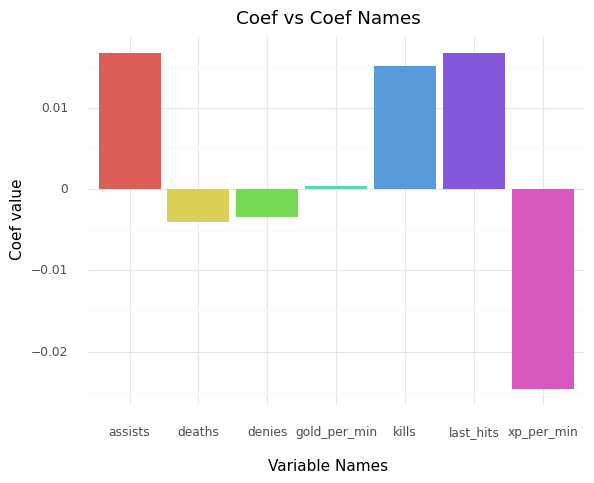

<ggplot: (8734084579705)>

In [ ]:
# Coefs
model = model_with_all_features['model']
coefficients = pd.DataFrame({"Coef" : model.coef_.flatten(), "Variable Names" : predictors})

# # Graph
# coefficients
(ggplot(coefficients, aes(x = "Variable Names", y = "Coef", fill = "Variable Names" )) + 
 theme_minimal() +
 labs(x="\nVariable Names", y="Coef value") +
 geom_bar(stat = "identity") +
 ggtitle("Coef vs Coef Names") + 
 theme(legend_position = "none"))

From the above coefficient comparison chart, we can see that xp_per_min is the strongest predictor of if a player will win. That said, the model still did not perform well, so we can take it with a grain of salt. Based on my impression of the model, let's see how this attribute changes when we remove one predictor at a time and remake the model.

In [ ]:
accs = []
mses = []
r2s = []
coefs = []

for feature in predictors:
  new_preds = predictors.copy()
  new_preds.remove(feature)
  results = do_logistic_regression(q1_data, new_preds, product)

  accs.append(results['accuracy_score'])
  mses.append(results['MSE'])
  r2s.append(results['R2'])
  coefs.append([results['model'].coef_.flatten()])

In [ ]:
rd = pd.DataFrame({'field': [], 'value': []})

for i in range(len(predictors)):
  rd.loc[len(rd.index)] = ['acc', accs[i]]
  rd.loc[len(rd.index)] = ['mse', mses[i]]
  rd.loc[len(rd.index)] = ['r2', r2s[i]]

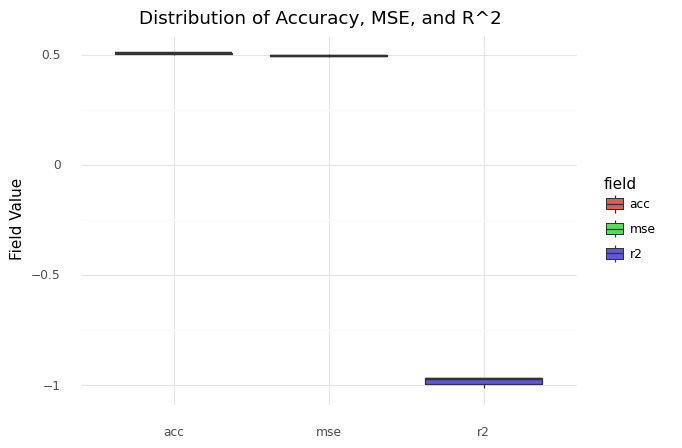

<ggplot: (8734084435281)>

In [ ]:
(ggplot(rd, aes(x = "field",
                y = "value",
                fill='field')) +
 geom_boxplot() +
 ggtitle("Distribution of Accuracy, MSE, and R^2") +
 labs(x = "", y = "Field Value") +
 theme_minimal()
) 

This graph indicates that throughout the test of re-doing the model without one feature at a time barely changed the accuracy, MSE, or R^2 score. Each remained within small bounds around the same value.

Lets have a look at the coefficients when we remove one predictor at a time and remake the model. Will the coefficients stabilie?

In [ ]:
new_coefs = []
for l in coefs:
  for _l in l:
    try:
      new_coefs.append(list(_l))
    except:
      continue

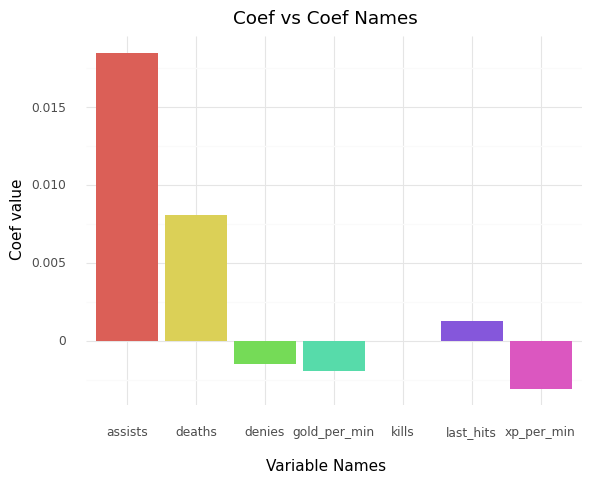

<ggplot: (8734084640077)>

In [ ]:
new_coefs[0].insert(0, 0)
coefficients = pd.DataFrame({"Coef" : new_coefs[0], "Variable Names" : predictors})

# # Graph
# coefficients
(ggplot(coefficients, aes(x = "Variable Names", y = "Coef", fill = "Variable Names" )) + 
theme_minimal() +
labs(x="\nVariable Names", y="Coef value") +
geom_bar(stat = "identity") +
ggtitle("Coef vs Coef Names") + 
theme(legend_position = "none"))


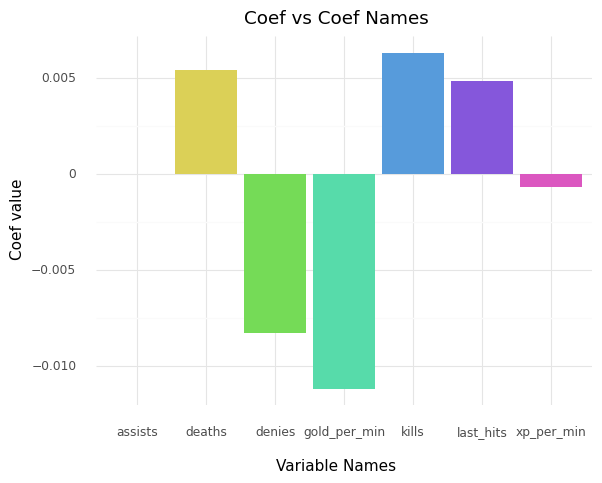

<ggplot: (8734084642233)>

In [ ]:
new_coefs[1].insert(1, 0)
coefficients = pd.DataFrame({"Coef" : new_coefs[1], "Variable Names" : predictors})

# # Graph
# coefficients
(ggplot(coefficients, aes(x = "Variable Names", y = "Coef", fill = "Variable Names" )) + 
theme_minimal() +
labs(x="\nVariable Names", y="Coef value") +
geom_bar(stat = "identity") +
ggtitle("Coef vs Coef Names") + 
theme(legend_position = "none"))

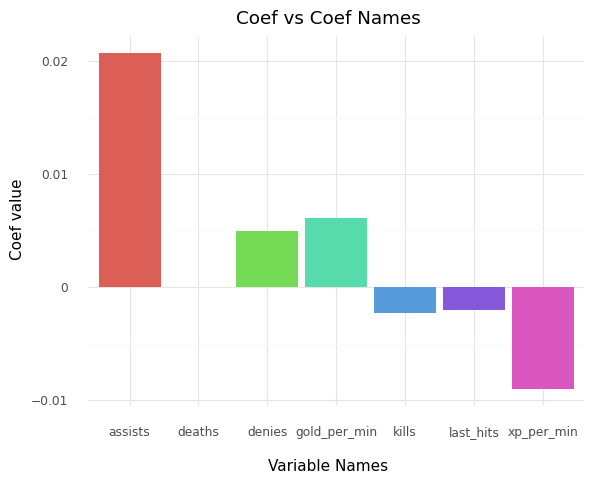

<ggplot: (8734084504977)>

In [ ]:
new_coefs[2].insert(2, 0)
coefficients = pd.DataFrame({"Coef" : new_coefs[2], "Variable Names" : predictors})

# # Graph
# coefficients
(ggplot(coefficients, aes(x = "Variable Names", y = "Coef", fill = "Variable Names" )) + 
theme_minimal() +
labs(x="\nVariable Names", y="Coef value") +
geom_bar(stat = "identity") +
ggtitle("Coef vs Coef Names") + 
theme(legend_position = "none"))

Note that the missing values are because that specific value was removed from the model, but I have still included it for reference by inserting a zero for its value. Thus our fears were confirmed: the coefficients do not stabilize, indicating that there is very little to no correlation between each feature and the product. I will discuss this idea more soon.

In [ ]:
mean_results_data = pd.DataFrame({'Set': ['Accuracy', 'MSE', 'R^2'], 'Value': [np.mean(accs), np.mean(mses), np.mean(r2s)]})

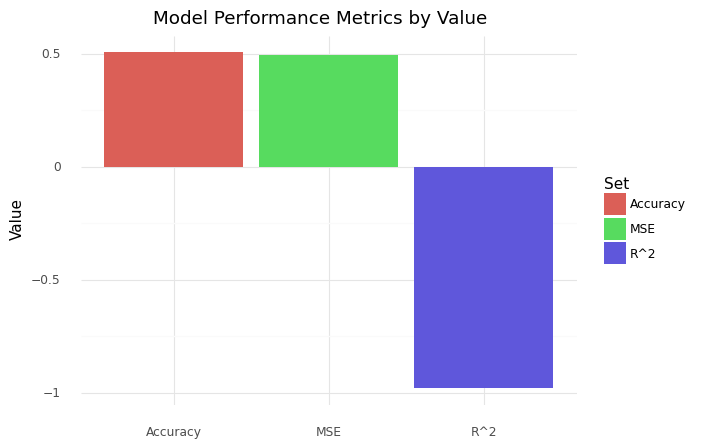

<ggplot: (8734084410777)>

In [ ]:
(ggplot(mean_results_data, aes(x = "Set", y = "Value", fill = "Set")) +
geom_bar(stat='identity') + theme_minimal() + 
labs(x = "",
    y = "Value",
    title = "Model Performance Metrics by Value"))

**Question 1: Discussion**

We can see that the accuracy and R^2 scores are less than great; bad, in fact. However, the mean MSE was very low at around .493. This indicates that the model actually performed well. Thus, despite the model performing well, why is the R^2 score and accuracy so low? The very low R^2 score (around -.972) indicates that there is very little correlation between our features and our predictor. Our low accuracy score (around 0.506) is a product of this performance. This trend stayed apparent through the test as I removed one feature at a time from the model. Thus, this supports the hypothesis that the used features are not a good way to predict whether a player will win the game or not. 

## **Question 2: Data Setup!**

In [ ]:
# for this question I will need item_id (purchase_log, continuous), time (purchase_log, continuous), hero_id (player, continuous), item_slot_0 (player, continuous), 
# item_slot_1 (player, continuous), item_slot_2 (player, continuous), item_slot_3 (player, continuous), item_slot_4 (player, continuous), and item_slot_5 (player, continuous).

q2_data = create_secondary_dataframe([purchase_log, player_data], {0: ['item_id', 'time'], 1: ['hero_id', 'item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5']})
q2_data.dropna(inplace=True)
q2_data.reset_index(inplace=True)
q2_data

,index,item_id,time,hero_id,item_0,item_1,item_2,item_3,item_4,item_5
0,0,44,-81,86.0,180.0,37.0,73.0,56.0,108.0,0.0
1,1,29,-63,51.0,46.0,63.0,119.0,102.0,24.0,108.0
2,2,43,6,83.0,48.0,60.0,59.0,108.0,65.0,0.0
3,3,84,182,11.0,63.0,147.0,154.0,164.0,79.0,160.0
4,4,46,197,67.0,114.0,92.0,147.0,0.0,137.0,63.0
...,...,...,...,...,...,...,...,...,...,...
99045,99045,46,502,41.0,145.0,158.0,172.0,63.0,247.0,114.0
99046,99046,27,547,93.0,160.0,123.0,63.0,249.0,36.0,143.0
99047,99047,46,547,18.0,63.0,114.0,141.0,156.0,0.0,247.0
99048,99048,46,669,20.0,98.0,139.0,114.0,117.0,63.0,168.0


In [ ]:
item_id_to_name = {}

for index in range(item_ids.shape[0]):  
  item_id_to_name[item_ids["item_id"].iloc[index]] = item_ids["item_name"].iloc[index]

In [ ]:
items_purchased_by_game = {}

for index in range(20001):
  if purchase_log['match_id'].iloc[index] in items_purchased_by_game.keys():
    items_purchased_by_game[purchase_log['match_id'].iloc[index]].append(purchase_log['item_id'].iloc[index]) 
  else:
    items_purchased_by_game[purchase_log['match_id'].iloc[index]] = [purchase_log['item_id'].iloc[index]]

print(len(items_purchased_by_game))

55


In [ ]:
data_by_game = pd.DataFrame(np.array([list(items_purchased_by_game.values())]), columns = list(items_purchased_by_game.keys()))
data_by_game

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,"[44, 29, 43, 84, 46, 13, 44, 46, 20, 73, 46, 1...","[44, 45, 39, 38, 38, 38, 42, 46, 34, 29, 46, 3...","[182, 44, 20, 16, 16, 41, 36, 34, 29, 46, 12, ...","[45, 16, 16, 38, 38, 44, 42, 29, 180, 59, 42, ...","[44, 182, 216, 16, 16, 14, 71, 14, 34, 29, 20,...","[14, 14, 71, 182, 44, 29, 46, 18, 25, 63, 20, ...","[42, 42, 45, 44, 38, 38, 16, 16, 46, 29, 84, 4...","[12, 44, 38, 38, 16, 16, 42, 28, 29, 25, 88, 4...","[44, 11, 182, 3, 5, 57, 69, 145, 56, 29, 14, 4...","[45, 20, 44, 39, 38, 16, 27, 94, 13, 42, 42, 7...",...,"[27, 12, 38, 29, 214, 54, 46, 46, 46, 137, 53,...","[182, 39, 44, 16, 216, 46, 182, 12, 29, 27, 21...","[44, 14, 14, 71, 182, 29, 20, 16, 16, 36, 34, ...","[20, 15, 77, 44, 65, 25, 29, 39, 38, 25, 17, 6...","[44, 39, 182, 11, 16, 12, 88, 28, 29, 12, 214,...","[44, 14, 14, 71, 182, 29, 25, 63, 17, 22, 22, ...","[20, 15, 77, 16, 16, 41, 34, 29, 36, 20, 46, 4...","[20, 16, 16, 36, 34, 44, 29, 25, 17, 63, 46, 4...","[44, 39, 182, 16, 16, 46, 41, 29, 46, 180, 59,...","[44, 16, 16, 12, 11, 29, 27, 214, 46, 46, 34, ..."


## **Question 2**

At what point in the match are certain items generally bought? Use graphs to visualize this. Using a linear regression model, can we predict hero_id given item_slot_0, item_slot_1, item_slot_2, item_slot_3, item_slot_4, item_slot_5. What do the R^2 and MSE reveal about the model?

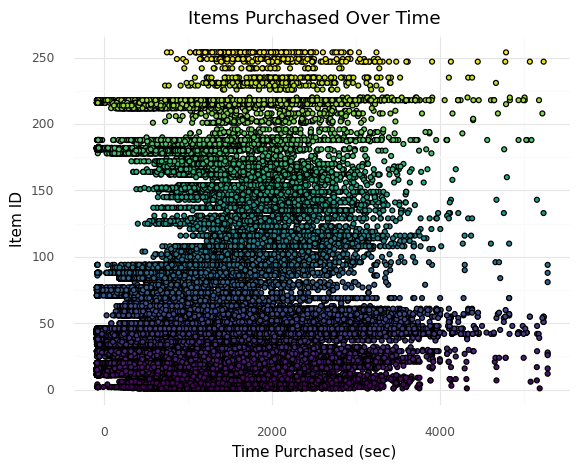

<ggplot: (8734084500425)>

In [ ]:
# Lets visualize our data

(ggplot(q2_data, aes(x = "time",
                y = "item_id",
                fill='item_id')) +
 geom_point() +
 ggtitle("Items Purchased Over Time") +
 labs(x = "Time Purchased (sec)", y = "Item ID") +
 theme_minimal() +
 theme(legend_position = "none")
) 

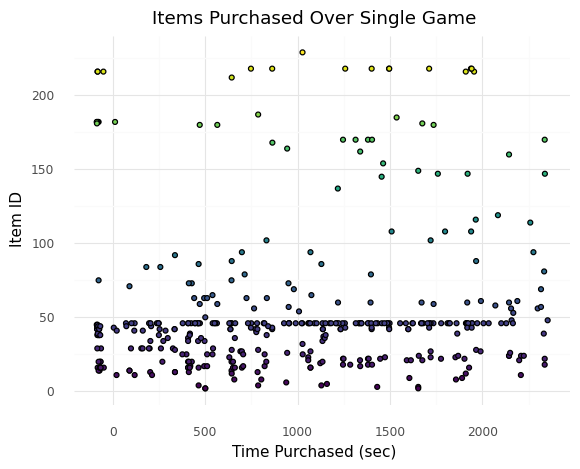

<ggplot: (8734081403917)>

In [ ]:
# Woah! That's a lot of data. Lets break it down smaller so we can see what we are working with.

(ggplot(q2_data[0:397], aes(x = "time",
                y = "item_id",
                fill='item_id')) +
 geom_point() +
 ggtitle("Items Purchased Over Single Game") +
 labs(x = "Time Purchased (sec)", y = "Item ID") +
 theme_minimal() +
 theme(legend_position = "none")
) 

This is more readable. We can definitely see trends in what items players purchase over time. These data points correspond to all items purchased in a single game. Each y level corresponds to an item, so following the line it makes going across the graph tells us how often that item was purchased over the course of the game. However, without the names of the items it is hard to understand fully. I can make an educated guess the the line around y=48 is the teleport scroll, an item that is cheap and constantly in need, which is why it is bought consistently througout the game. My initial idea was to use a clustering algorithm to visualie this, but... this data is technically already visualized using the graphs! Simply using the color-fill mechanic in ggplot shows us the clusters by item_id. Lets dig a little deeper into this and grab the names of the most common items bought here.

In [ ]:
def get_n_most_common(dataframe, col, n=5, start=0, stop=1000):

  most_common = {}
  col_list = dataframe[col].iloc[start:stop].tolist()

  for i in col_list:
    most_common[i] = col_list.count(i)

  return list({k: v for k, v in sorted(most_common.items(), key=lambda item: item[1])})[-n:]

In [ ]:
most_common = get_n_most_common(q2_data, "item_id", stop=397)
for index in range(len(most_common)):
  print(item_id_to_name[most_common[index]])

tango
circlet
branches
ward_observer
tpscroll


Looks like I was wrong! The tango, an early game item, is the most commonly bought item in this game! This is surprising since the game went on for at least 38 minutes, indicating that this value should have dropped off. Let's move on to the linear regression...

In [ ]:
# LR
predictors = ['item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5']
product = 'hero_id'

X = q2_data[predictors]
y = q2_data[product]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#zscore
z = StandardScaler()
z.fit(X_train)
X_train = z.transform(X_train)
X_test = z.transform(X_test)

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
results['model'] = lr
results['preds'] = lr.predict(X_test)
results['R2'] = r2_score(y_test, results['preds'])
results['MSE'] = mean_squared_error(y_test, results['preds'])

print("R^2 score: " + str(results['R2']))
print("MSE score: " + str(results['MSE']))

R^2 score: 0.0032593318789663206
MSE score: 1066.977987514569


I'm starting to see a trend from our models; low R^2 scores! What does this mean? This means that there is little to no correlation between our features and our product. In the sense of the data's source, Dota 2, this makes sense. As for the MSE, the model observed values that were far from the actual ones. See below for my explanation.

## **A IMPORTANT Note on Dota 2**

Dota 2 is a video game played by unpredictable humans. There is plenty of logic to Dota 2 and the way it is played, including logic to what heroes buy what items. However, this is often defined by what's called the 'meta.' Meta is, put simply: what's the best thing to do and what are most people doing? The best thing and what most people do are not always the same, but generally are very alike. The issue with this data is that it is from public matches, i.e. matches played casually by millions of people. Everyone has a different idea of what to do, what to buy, how to get gold, kills, and a skill level that in many may is a causal factor of the mentioned statistics. If this data set were purely professional match data, the trends would become clearer. Roles are more understood and the responsabilities of each role, including what each player (hero) buys is is clear; lines are far less blurred than they are in public matches. However, there are some aspects of the game which remain constant. The majority of games are close at first, then as the game progresses one team gains a substantial lead in gold. This is reflected in items. Thus, while predicting a hero based on items may be like searching for a needle in a haystack, I think we would get better results if we wanted to predict if a player would *win* based on their items. Let's explore this below. **Source and credibility goes to my many hundreds of hours playing this game growing up!

## **Question 2.5 - Data Setup!**

In [ ]:
# we need a dataset with rad_win (match, binary), item_id (item_ids, continuous), hero_id (player, continuous),  item_slot_0 (player, continuous), 
# item_slot_1 (player, continuous), item_slot_2 (player, continuous), item_slot_3 (player, continuous), item_slot_4 (player, continuous), item_slot_5 (player, continuous).
# We can re-use the dataset used in question 2.

data = q2_data.drop('time', axis=1)

In [ ]:
data.head()

,index,item_id,hero_id,item_0,item_1,item_2,item_3,item_4,item_5
0,0,44,86.0,180.0,37.0,73.0,56.0,108.0,0.0
1,1,29,51.0,46.0,63.0,119.0,102.0,24.0,108.0
2,2,43,83.0,48.0,60.0,59.0,108.0,65.0,0.0
3,3,84,11.0,63.0,147.0,154.0,164.0,79.0,160.0
4,4,46,67.0,114.0,92.0,147.0,0.0,137.0,63.0


In [ ]:
q2_5_data = create_secondary_dataframe([purchase_log, player_data], {0: ['item_id', 'player_slot', 'match_id'], 1: ['item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5']}, False) # since we have two columns called 'match_id' we can't overide
q2_5_data.head()

,item_id,player_slot,match_id,item_0,item_1,item_2,item_3,item_4,item_5
0,44,0,0,180.0,37.0,73.0,56.0,108.0,0.0
1,29,0,0,46.0,63.0,119.0,102.0,24.0,108.0
2,43,0,0,48.0,60.0,59.0,108.0,65.0,0.0
3,84,0,0,63.0,147.0,154.0,164.0,79.0,160.0
4,46,0,0,114.0,92.0,147.0,0.0,137.0,63.0


In [ ]:
q2_5_data.dropna(inplace=True)
q2_5_data.reset_index(inplace=True)

In [ ]:
q2_5_data = replace_col_by_conditions(q2_5_data, "player_slot", ['is_radiant'], [[0, 0], [0,4], [128, 132]], [1, 0], True)

The below method has an awful execution time, but it is a necessary step. I am sure there is a more efficient way to do this, but this works! What this is doing is comparing values in one dataset to values in the other and manipulating data based on that comparison.

In [ ]:
q2_5_data['won_game'] = 0
for index in range(q2_5_data.shape[0]):
  curr_match = q2_5_data['match_id'].iloc[index]
  for i in range(q2_5_data.shape[0]):
    if match_data['match_id'].iloc[i] == curr_match:
      if match_data['radiant_win'].iloc[i] == q2_5_data['is_radiant'].iloc[index]:
        q2_5_data['won_game'].iloc[index] = 1
      break

In [ ]:
q2_5_data.drop(columns=['match_id', 'is_radiant'])

,index,item_id,item_0,item_1,item_2,item_3,item_4,item_5,won_game
0,0,44,180.0,37.0,73.0,56.0,108.0,0.0,1
1,1,29,46.0,63.0,119.0,102.0,24.0,108.0,1
2,2,43,48.0,60.0,59.0,108.0,65.0,0.0,1
3,3,84,63.0,147.0,154.0,164.0,79.0,160.0,1
4,4,46,114.0,92.0,147.0,0.0,137.0,63.0,1
...,...,...,...,...,...,...,...,...,...
99045,99045,46,145.0,158.0,172.0,63.0,247.0,114.0,1
99046,99046,27,160.0,123.0,63.0,249.0,36.0,143.0,1
99047,99047,46,63.0,114.0,141.0,156.0,0.0,247.0,1
99048,99048,46,98.0,139.0,114.0,117.0,63.0,168.0,1


## **Question 2.5**

Using linear regression, logistic regression, and KNN, which model best predicts whether a player will win based on the items they have at the end of the game?

In [ ]:
# setup
predictors = ['item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5']
product = ['won_game']

X = q2_5_data[predictors]
y = q2_5_data[product]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

z = StandardScaler()
z.fit(X_train)
X_train = z.transform(X_train)
X_test = z.transform(X_test)

In [ ]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

results = {}
results['model'] = lr
results['preds'] = lr.predict(X_test)
results['R2'] = r2_score(y_test, results['preds'])
results['MSE'] = mean_squared_error(y_test, results['preds'])

print("R^2 score: " + str(results['R2']))
print("MSE score: " + str(results['MSE']))

R^2 score: -0.0002555875279997011
MSE score: 0.2491029955901063


In [ ]:
linear_score = lr.score(X_test, y_test)

In [ ]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

results['model'] = lr
results['preds'] = lr.predict(X_test)
results['R2'] = r2_score(y_test, results['preds'])
results['MSE'] = mean_squared_error(y_test, results['preds'])

print("R^2 score: " + str(r2_score(y_test, lr.predict(X_test))))
print("MSE score: " + str( mean_squared_error(y_test, results['preds'])))

R^2 score: -0.883258864911113
MSE score: 0.4690055527511358


In [ ]:
logistic_score = lr.score(X_test, y_test)

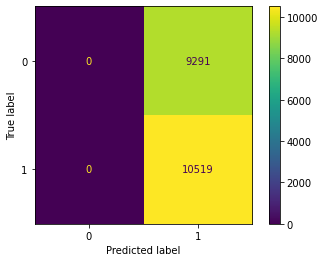

In [ ]:
plot_confusion_matrix(lr, X_test, y_test)

In [ ]:
# KNN
knn = KNeighborsClassifier()
ks = {'n_neighbors': range(1, 30)}

grid = GridSearchCV(knn, ks, scoring='accuracy', cv=5)

knnmod = grid.fit(X_train, y_train)

In [ ]:
knn_score = knnmod.score(X_test, y_test)
print("Best: " + str(knnmod.best_score_))
print("Score: " + str(knnmod.score(X_test, y_test)))

Best: 0.5089601211509339
Score: 0.508833922261484


In [ ]:
print("R^2: " + str(r2_score(y_test, knnmod.predict(X_test))))
print("MSE: " + str(mean_squared_error(y_test, knnmod.predict(X_test))))

R^2: -0.970178214015393
MSE: 0.4911660777385159


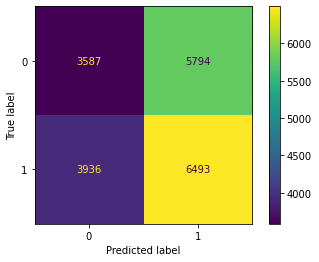

In [ ]:
plot_confusion_matrix(knnmod, X_test, y_test)

In [ ]:
q2_model_data = pd.DataFrame({"Set": ['Linear Regression', 'Logistic Regression', 'KNN'], 'Value': [linear_score, logistic_score, knn_score]})

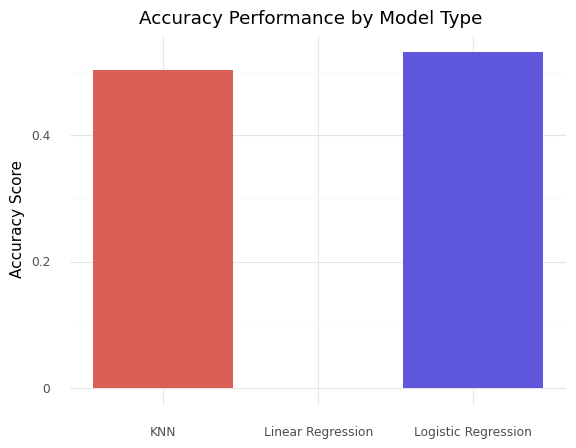

<ggplot: (8734080753357)>

In [ ]:
(ggplot(q2_model_data, aes(x = "Set", y = "Value", fill = "Set")) +
geom_bar(stat='identity') + theme_minimal() + 
labs(x = "",
    y = "Accuracy Score",
    title = "Accuracy Performance by Model Type") +
 theme(legend_position='none'))

From the above data we can see there is still pretty much no correlation between a heroes items at the end of the game and whether or not they won. This is shown in the R^2 score for both the linear and logistic models. Both of them are negative as well, meaning some variance in the data could not be understood. In earlier questions we found a much higher (lower?) negative score, indicating that far more variation could not be explained. At least we're getting somewhere, but there is still no realistic correlation. Our MSEs are fairly good however, as well as the accuracy score from our KNN model. This indicates that there is less of a different between our actual and predicted values. Although this seems like a conundrum: no correlation but decent ability to predict? I believe this is explained by the fact that some a player can win a game with a set of items and then lose the next one with the same set of items just as easily. This is, in many ways, the impact of player data. Thus, this furthers the idea that the ability to predict a victor is deceivingly difficult. However, what if we take into account variables that have less to do with the players themselves, and more to do with the makeup of the game?

## **Question 3 - Data Setup!**


In [ ]:
q3_data = create_secondary_dataframe([match_data], {0: ['tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire', 'radiant_win']})
q3_data.head(15)

,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire,radiant_win
0,1982,4,63,3,True
1,0,1846,0,63,False
2,256,1972,48,63,False
3,4,1924,3,51,False
4,2047,0,63,0,True
5,2047,4,63,3,True
6,1972,0,63,3,True
7,2046,0,63,0,True
8,0,1982,0,63,False
9,0,1972,0,63,False


In [ ]:
q3_data.dropna(inplace=True)
q3_data.reset_index(inplace=True)

## **Question 3**

Predict whether radiant will win or not using tower_status_radiant, tower_status_dire, barracks_status_radiant, and barracks_status_dire. Implement a logistic regression model and decision tree and record accuracy and MSE using TTS model validation. How did tree depth affect the fit of the model? What do the accuracy and MSE scores tell you about the model? Furthermore, implement the method simTree(...) and compare accuracy scores at different depth restrictions.


In [ ]:
# Setup
predictors = ['tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire']
product = 'radiant_win'

X = q3_data[predictors]
y = q3_data[product]
y = y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

z = StandardScaler()
z.fit(X_train)
X_train = z.transform(X_train)
X_test = z.transform(X_test)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

results = {}
results['model'] = lr
results['preds'] = lr.predict(X_test)
results['R2'] = r2_score(y_test, results['preds'])
results['MSE'] = mean_squared_error(y_test, results['preds'])

print("R^2 score: " + str(r2_score(y_test, lr.predict(X_test))))
print("MSE score: " + str( mean_squared_error(y_test, results['preds'])))

R^2 score: 0.9683048181009499
MSE score: 0.0079


Wow! Well... that's great! Nearly marks across the board. But it doesn't feel... right, does it. The values for the predictors are actually integer representations of binary numbers which actually represent an integer between either 0-11 or 0-6. This begs the question of if the drastically larger numbers increased the mean, and thereby the standard deviation, by too much. Let's change it up and see if we get something different.

In [ ]:
# lets change it from tower_status_x to 'towers_alive_x', and do the same with barracks
# run at your own risk!
new_q3 = q3_data
for index in range(int(new_q3.shape[0])):
  t_alive_r = 0
  t_alive_d = 0
  b_alive_r = 0
  b_alive_d = 0
  for col in predictors:
    bin_str = format(new_q3[col].iloc[index], 'b')
    for n in bin_str:
      if n == '1':
        if col == 'tower_status_radiant':
          t_alive_r += 1
          new_q3[col].iloc[index] = t_alive_r
        elif col == 'tower_status_dire':
          t_alive_d += 1
          new_q3[col].iloc[index] = t_alive_d
        elif col == 'barracks_status_radiant':
          b_alive_r += 1
          new_q3[col].iloc[index] = b_alive_r
        elif col == 'barracks_status_dire':
          b_alive_d += 1
          new_q3[col].iloc[index] = b_alive_d

new_q3.head()

,index,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire,radiant_win
0,0,9,1,6,2,True
1,1,0,7,0,6,False
2,2,1,7,2,6,False
3,3,1,5,2,4,False
4,4,11,0,6,0,True


In [ ]:
# new LR
X = new_q3[predictors]
y = new_q3[product]
y = y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

z = StandardScaler()
z.fit(X_train)
X_train = z.transform(X_train)
X_test = z.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)

results = {}
results['model'] = lr
results['preds'] = lr.predict(X_test)
results['R2'] = r2_score(y_test, results['preds'])
results['accuracy_score'] = accuracy_score(y_test, results['preds'])
results['MSE'] = mean_squared_error(y_test, results['preds'])

print("Accuracy score: " + str(results['accuracy_score']))
print("R^2 score: " + str(results['R2']))
print("MSE score: " + str(results['MSE']))

Accuracy score: 0.9778
R^2 score: 0.9110415792860558
MSE score: 0.0222


Similar scoring! This indicates that there is great correlation between the status of a teams buildings and whether or not they will win. This makes sense because the game cannot be won unless most of these buildings are destroyed. Furthermore, there are non-player-controlled units (NPCs) called *creeps* that constantly spawn and move to attack enemy buildings. Thus, these factors are a little more outside the impact of the players' item and hero decisions. 

The original LR model yielded an R^2 of 0.96 and an MSE of 0.01. This indicates that there is both great correlation between the variables and the product and that the predicted values are very close to the actual ones. Let's move on to the DTree.

In [ ]:
# Decision tree, using the same TTS values
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_pred = tree.predict(X_test)

dtree_acc = accuracy_score(y_pred, y_test)
print("Accuracy: " + str(dtree_acc))

Accuracy: 0.9854


In [ ]:
dtree_mse = mean_squared_error(y_test, y_pred)
print("MSE: " + str(dtree_mse))

MSE: 0.0146


In [ ]:
dtree_r2 = r2_score(y_test, y_pred)
print("R^2: " + str(dtree_r2))

R^2: 0.941495813404343


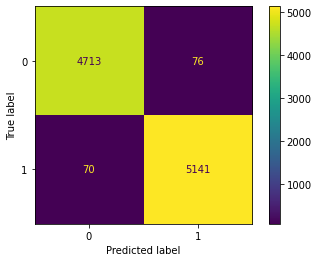

In [ ]:
plot_confusion_matrix(tree,X_test,y_test)

In [ ]:
lr_data = pd.DataFrame({"Set": ['Accuracy', 'MSE', 'R^2'], 'Value': [dtree_acc, dtree_mse, dtree_r2]})

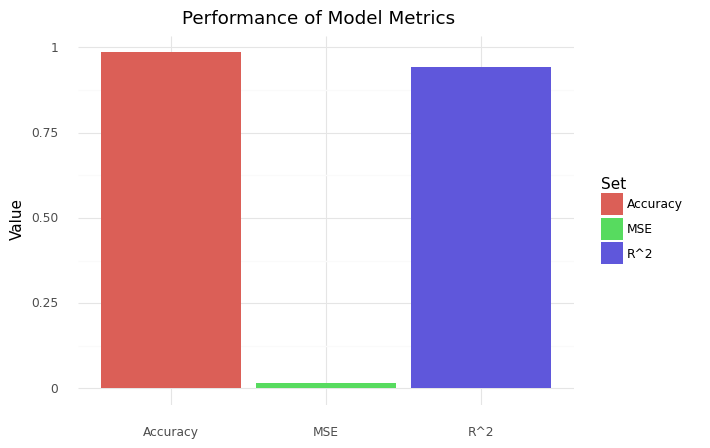

<ggplot: (8734081328429)>

In [ ]:
(ggplot(lr_data, aes(x = "Set", y = "Value", fill = "Set")) +
geom_bar(stat='identity') + theme_minimal() + 
labs(x = "",
    y = "Value",
    title = "Performance of Model Metrics"))

In [ ]:
# now lets make use of the sim_tree() function from class to test trees with other depth restrictions
def simTree(X_train, y_train, X_test, y_test, n = 200, max_depth = "none"):
    
    # X = data[predictors]
    # y = data[product]
    # X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

    
    #---build models------------------------------------
    
    # if there is no max depth, build regular tree
    if max_depth == "none":
        tree = DecisionTreeClassifier() 
        
    # otherwise, set max_depth
    else:
        tree = DecisionTreeClassifier(max_depth = max_depth)
        
    tree.fit(X_train,y_train)
    
    
    #---get training and test Accuracy---------------------
    train_acc = accuracy_score(y_train,tree.predict(X_train))
    test_acc = accuracy_score(y_test,tree.predict(X_test))

    y_pred = tree.predict(X_test)
    
    return(pd.DataFrame({"Set": ["Train", "Test",],
                        "Depth": [str(max_depth), str(max_depth)],
                        "Acc": [train_acc,
                               test_acc],
                         "MSE": mean_squared_error(y_test, y_pred),
                         "R^2": r2_score(y_test, y_pred)}))

In [ ]:
sims = [simTree(X_train, y_train, X_test, y_test, n = 2000, max_depth = x) for x in np.repeat(range(2,10), 100)]
sims = sims + [simTree(X_train, y_train, X_test, y_test, n = 2000, max_depth = "none") for i in range(0,100)]
sims_df = pd.concat(sims)

sims_df.head()

,Set,Depth,Acc,MSE,R^2
0,Train,2,0.9736,0.0255,0.897818
1,Test,2,0.9745,0.0255,0.897818
0,Train,2,0.9736,0.0255,0.897818
1,Test,2,0.9745,0.0255,0.897818
0,Train,2,0.9736,0.0255,0.897818


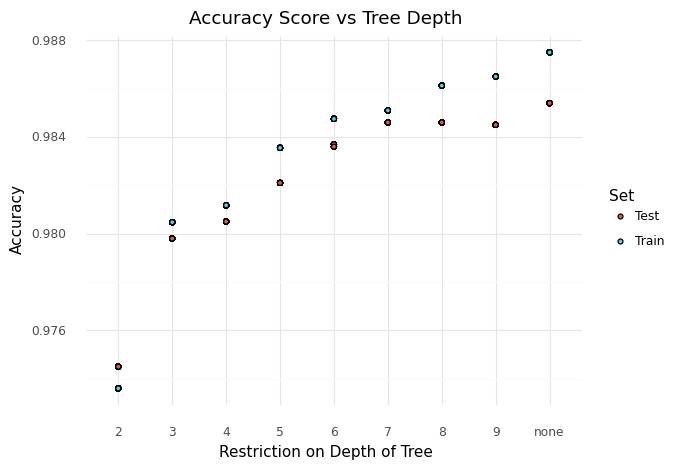

<ggplot: (8734081063941)>

In [ ]:
(ggplot(sims_df, aes(x = "Depth", y = "Acc", fill = "Set")) +
geom_point() + theme_minimal() + 
labs(x = "Restriction on Depth of Tree",
    y = "Accuracy",
    title = "Accuracy Score vs Tree Depth"))

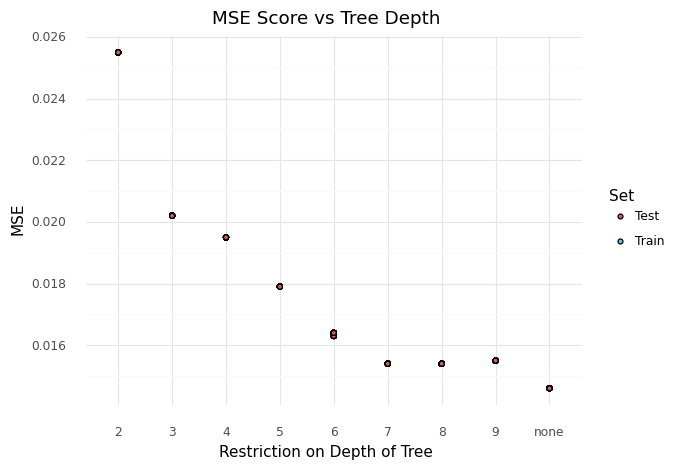

<ggplot: (8734081093569)>

In [ ]:
(ggplot(sims_df, aes(x = "Depth", y = "MSE", fill = "Set")) +
geom_point() + theme_minimal() + 
labs(x = "Restriction on Depth of Tree",
    y = "MSE",
    title = "MSE Score vs Tree Depth"))

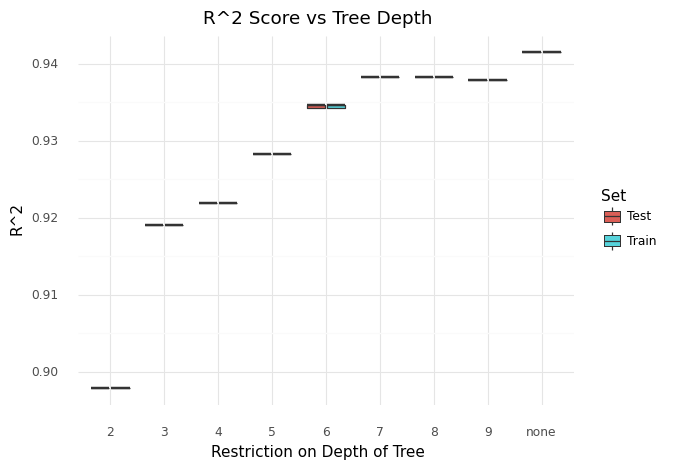

<ggplot: (8734081052937)>

In [ ]:
(ggplot(sims_df, aes(x = "Depth", y = "R^2", fill = "Set")) +
geom_boxplot() + theme_minimal() + 
labs(x = "Restriction on Depth of Tree",
    y = "R^2",
    title = "R^2 Score vs Tree Depth"))

From the above graph, as well as the statistics, we can say with confidence that there is a direct correlation between buildings destroyed and whether or not a team will win. Tree depth is very important here, indicated in the graphs above. If the depth is too small, we get worse results. If the restriction is none, we get the best results. This makes sense given the nature of our data; at least 5 towers **must** be destroyed to win the game, and any other building destroyed becomes an increasingly good indication of victory. This means if the only decision compared whether a team had destroyed 5 buildings we would receive a decent accuracy rating, but any subsequent buildings destroyed, and thus more decisions (and depth) the greater the accuracy of the model. 

## **One Final Note About Dota 2**
This project has unveiled that in many ways humans are the greatest contributions to inconsistent data, especially in the context of a video game where anything goes. This is important because human nature is harder to predict in an environment where there are no consequences. This is demonstrated in this project. When it comes to things like objectives, however, given the context of NPC units which in all ways are always trying to *win* the game, more confident predictions can be made. 